In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('Data/processed.csv')
df.head()

,date,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,showers,snowfall,pressure_msl,surface_pressure,cloud_cover,wind_speed_10m,wind_direction_10m,wind_gusts_10m,is_day,year,month,day,hour,cluster
0,2022-01-01,11.021500,93.0,8.542295,0.0,0.0,0.0,0.0,1019.9,1018.79724,7.0,16.981165,212.00534,51.12,0.0,2022,1,1,0,4
1,2022-01-01,10.521500,95.0,8.323380,0.0,0.0,0.0,0.0,1019.7,1018.59550,19.0,14.707222,201.54105,43.56,0.0,2022,1,1,1,4
2,2022-01-01,10.721499,96.0,8.677092,0.0,0.0,0.0,0.0,1019.8,1018.69610,100.0,14.345898,197.52567,39.96,0.0,2022,1,1,2,4
3,2022-01-01,11.071500,97.0,9.138726,0.0,0.0,0.0,0.0,1019.7,1018.59784,100.0,14.587776,195.75124,42.12,0.0,2022,1,1,3,4
4,2022-01-01,11.221499,96.0,8.969191,0.0,0.0,0.0,0.0,1019.5,1018.39825,100.0,16.766108,194.93147,49.32,0.0,2022,1,1,4,4


In [4]:
df.isna().sum()

date                    0
temperature_2m          0
relative_humidity_2m    0
apparent_temperature    0
precipitation           0
rain                    0
showers                 0
snowfall                0
pressure_msl            0
surface_pressure        0
cloud_cover             0
wind_speed_10m          0
wind_direction_10m      0
wind_gusts_10m          0
is_day                  0
year                    0
month                   0
day                     0
hour                    0
cluster                 0
dtype: int64

In [5]:
df.duplicated().sum()

np.int64(0)

### EDA

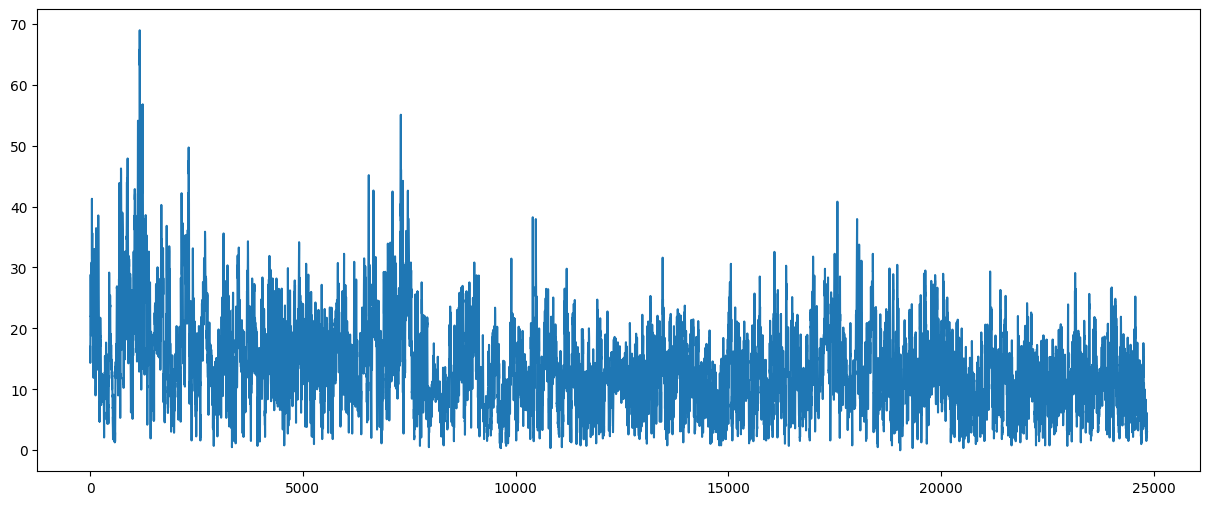

In [6]:
plt.figure(figsize=(15,6), dpi = 100) 
plt.plot(df['wind_speed_10m'], linestyle = 'solid') #solid, dashed, dashdot, dotted
plt.show()

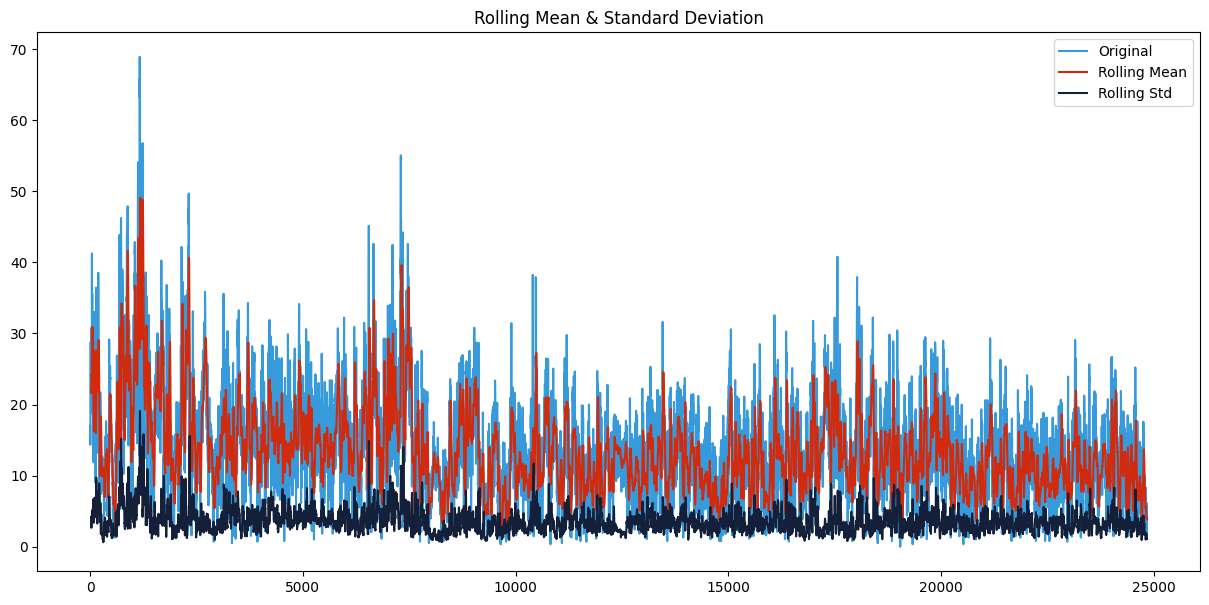

In [7]:
#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df["wind_speed_10m"], color='#379BDB', label='Original')
plt.plot(df["wind_speed_10m"].rolling(window=24).mean(), color='#D22A0D', label='Rolling Mean')
plt.plot(df["wind_speed_10m"].rolling(window=24).std(), color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

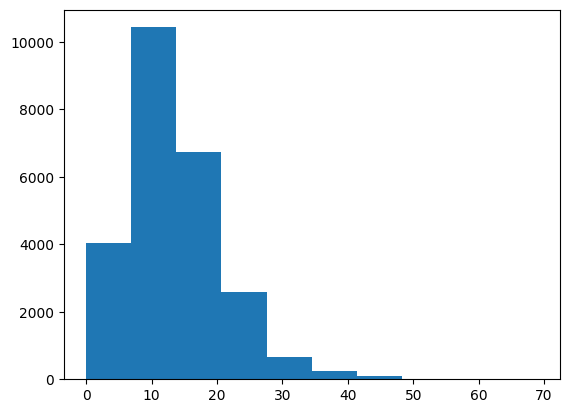

In [8]:
plt.hist(df['wind_speed_10m'])
plt.show()

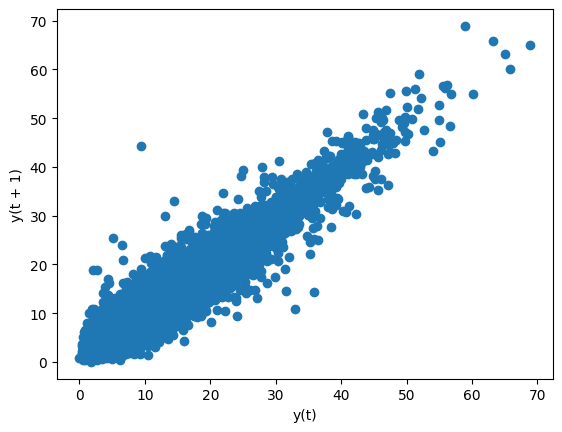

In [9]:
from pandas.plotting import lag_plot

lag_plot(df['wind_speed_10m'])
plt.show()

In [10]:
# Checking auto-correlation
from pandas import concat

btc_price = df['wind_speed_10m']
dataframe = concat([btc_price.shift(1), btc_price], axis=1)
dataframe.columns = ['t', 't+1']
result = dataframe.corr()
result

,t,t+1
t,1.000000,0.957909
t+1,0.957909,1.000000


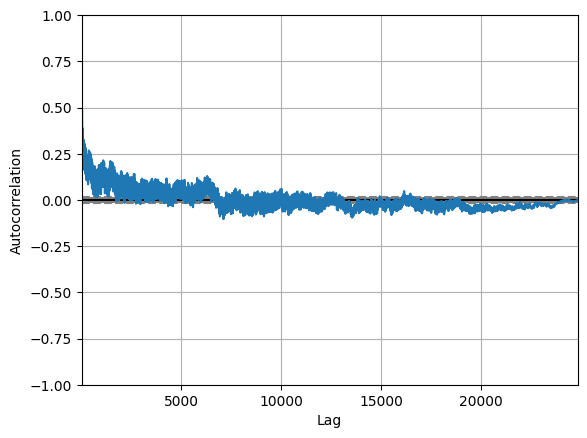

In [11]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['wind_speed_10m'])
plt.show()

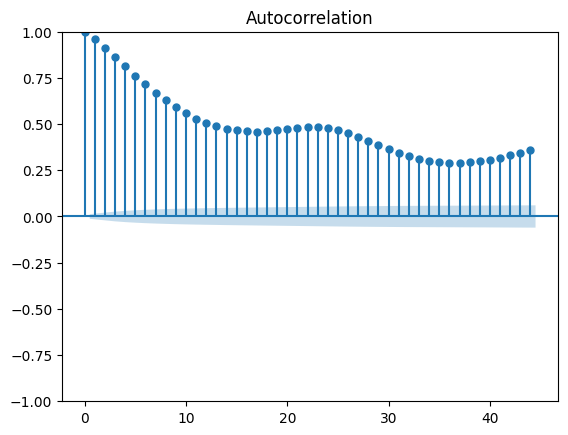

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['wind_speed_10m'])
plt.show()

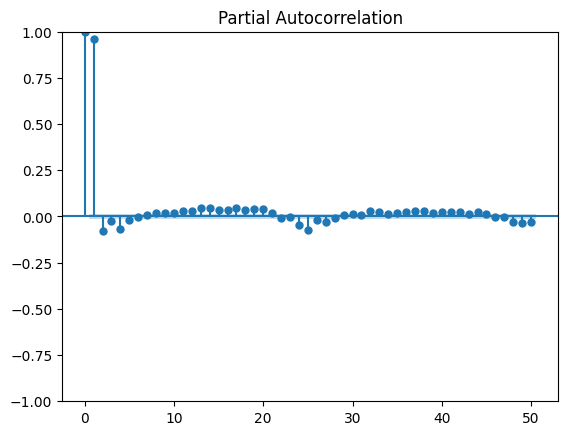

In [13]:
plot_pacf(df['wind_speed_10m'], lags=50)
plt.show()

### Data transformation

In [14]:
df = df.drop(['year', 'date'], axis = 1)
df.head(2)

,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,showers,snowfall,pressure_msl,surface_pressure,cloud_cover,wind_speed_10m,wind_direction_10m,wind_gusts_10m,is_day,month,day,hour,cluster
0,11.0215,93.0,8.542295,0.0,0.0,0.0,0.0,1019.9,1018.79724,7.0,16.981165,212.00534,51.12,0.0,1,1,0,4
1,10.5215,95.0,8.323380,0.0,0.0,0.0,0.0,1019.7,1018.59550,19.0,14.707222,201.54105,43.56,0.0,1,1,1,4


<Axes: >

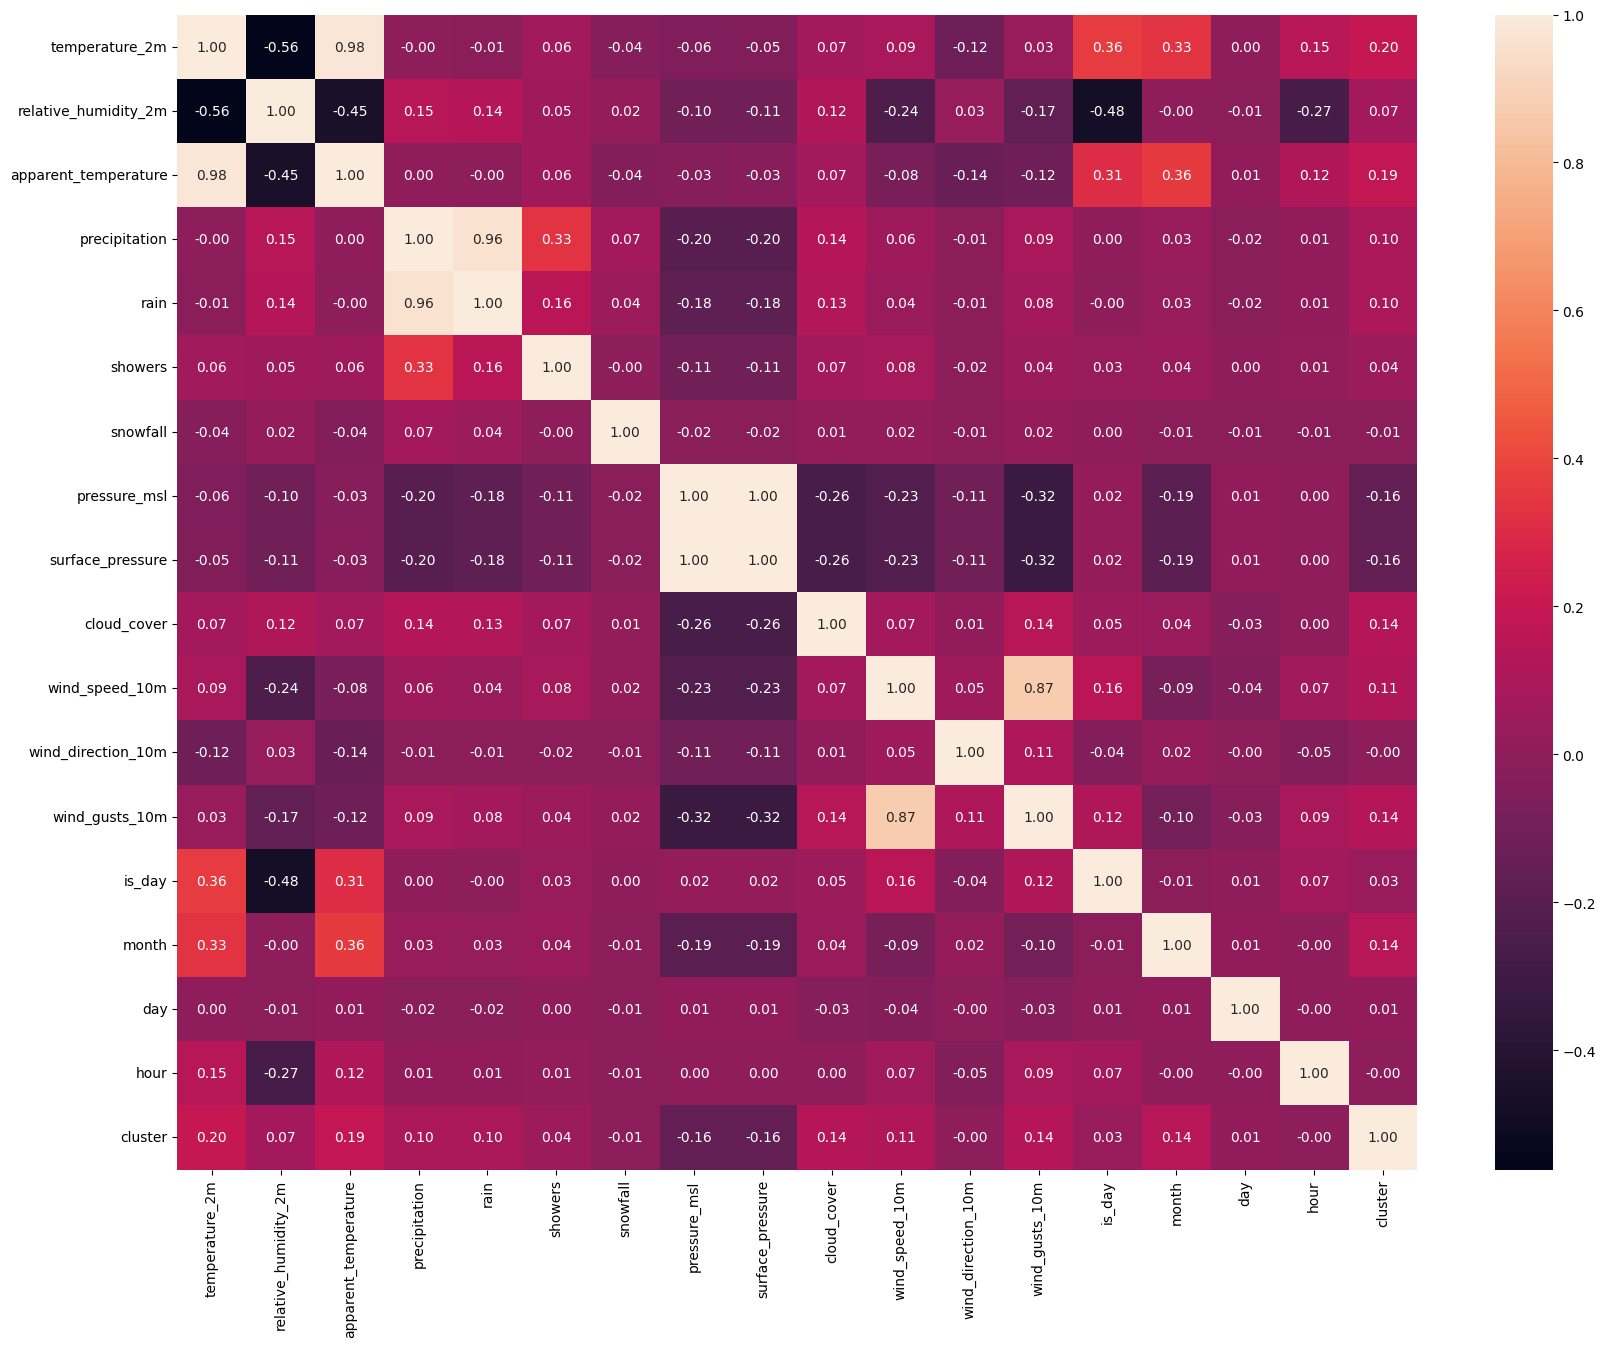

In [15]:
# Create correlation matrix heat map to check multi-collinearity between columns.

plt.figure(figsize = (20,15), dpi = 100)
sns.heatmap(df.corr(), annot = True, fmt = '.2f')

### Stationarity

In [16]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['wind_speed_10m'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -12.072368470013185
p-value: 2.331820780470828e-22


### Data Splitting and scaling

In [17]:
len(df.index) - (len(df.index) * 20 /100)

19872.0

In [18]:
train = df.iloc[:19872]
test = df.iloc[19872:]
test.reset_index(drop = True, inplace = True)

In [19]:
x_train = train.drop('wind_speed_10m', axis = 1)
y_train = train[['wind_speed_10m']]
x_test = test.drop('wind_speed_10m', axis = 1)
y_test = test[['wind_speed_10m']]

In [20]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(19872, 17)
(19872, 1)
(4968, 17)
(4968, 1)


### Feature Selection

In [21]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# Step 1: Standardize the features
x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_train = x_scaler.fit_transform(x_train)
y_train = y_scaler.fit_transform(y_train)

x_test = x_scaler.transform(x_test)
y_test = y_scaler.transform(y_test)

In [22]:
lasso = LassoCV(cv=5, random_state=42)  # 5-fold cross-validation
lasso.fit(x_train, y_train)

c:\Users\viren\Portfolio\Weather\.conda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\viren\Portfolio\Weather\.conda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.076e+01, tolerance: 1.987e+00
  model = cd_fast.enet_coordinate_descent(


LassoCV(cv=5, random_state=42)

In [23]:
# Get the coefficients
feature_names = list(train.columns)
feature_names.remove('wind_speed_10m')
lasso_coefficients = lasso.coef_

# Identify selected features
selected_features_indices = np.where(lasso_coefficients != 0)[0]
selected_feature_names = [feature_names[i] for i in selected_features_indices]
selected_coefficients = lasso_coefficients[selected_features_indices]

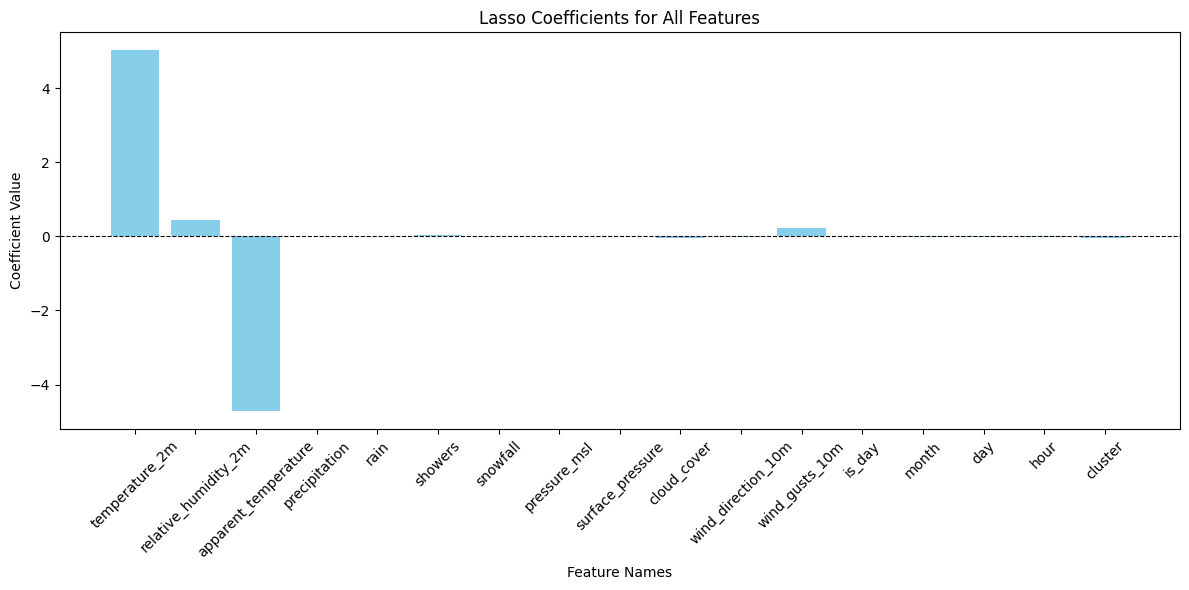

In [24]:
plt.figure(figsize=(12, 6))
plt.bar(feature_names, lasso_coefficients, color='skyblue')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title("Lasso Coefficients for All Features")
plt.xlabel("Feature Names")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

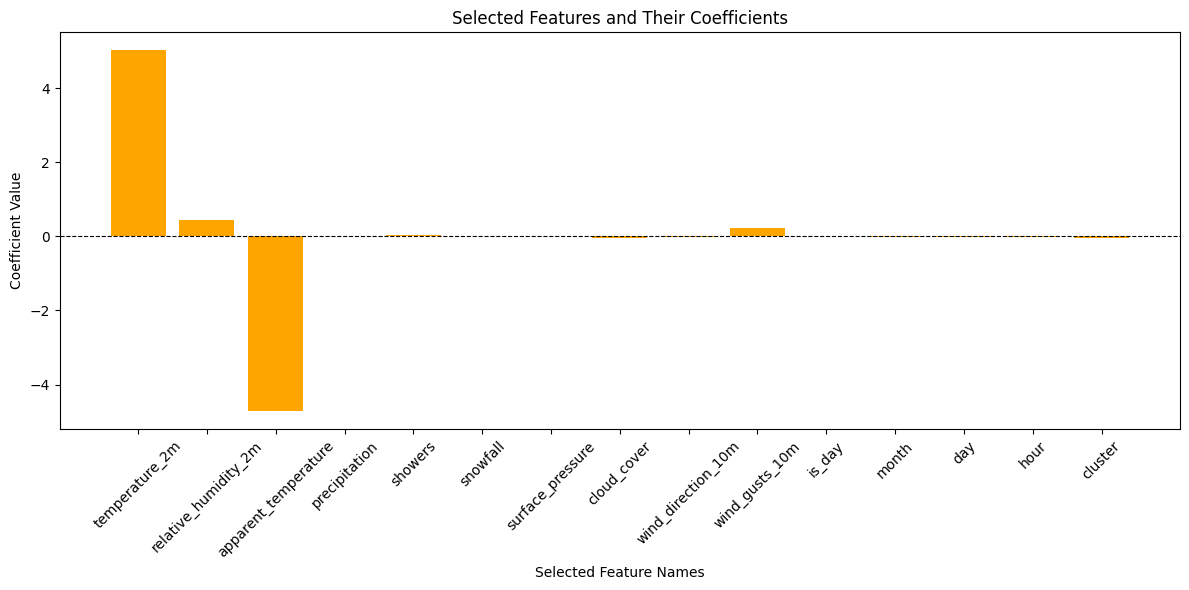

In [25]:
plt.figure(figsize=(12, 6))
plt.bar(selected_feature_names, selected_coefficients, color='orange')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title("Selected Features and Their Coefficients")
plt.xlabel("Selected Feature Names")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [26]:
selected_coefficients

array([ 5.01990565e+00,  4.35385614e-01, -4.71957612e+00, -1.71724340e-03,
        2.77898059e-02,  1.11327363e-03,  8.20503065e-03, -3.80503812e-02,
       -9.61316037e-03,  2.25687800e-01,  1.17758782e-02, -5.65822586e-03,
       -7.35128603e-03, -1.03309162e-02, -3.92773117e-02])

In [27]:
selected_features_indices

array([ 0,  1,  2,  3,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [28]:
x_train = x_train[:, selected_features_indices]
x_test = x_test[:, selected_features_indices]

### Machine learning

In [29]:
def mad_error(y_true, y_pred):
    # Ensure inputs are numpy arrays for vectorized operations
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate absolute deviations
    absolute_deviation = np.abs(y_true - y_pred)
    
    # Compute the mean of absolute deviations
    mad_error = np.mean(absolute_deviation)
    
    return mad_error

In [30]:
df1 = df[['wind_speed_10m', 'temperature_2m', 'apparent_temperature', 'precipitation', 'rain', 'showers', 'snowfall',
          'pressure_msl', 'surface_pressure', 'cloud_cover', 'wind_direction_10m', 'wind_gusts_10m', 'is_day', 'month', 'day',
          'hour', 'cluster']]

In [31]:
lagged_data = df1.copy()
for lag in range(1, 2):  # Create lags
    for col in df1.columns:
        lagged_data[f'{col}_lag_{lag}'] = df1[col].shift(lag)

In [32]:
for lag in range(1, 6):
    lagged_data[f'future_windspeed_{lag}'] = lagged_data['wind_speed_10m'].shift(-lag)

In [33]:
lagged_data = lagged_data.dropna()
lagged_data.reset_index(drop=True, inplace = True)

In [34]:
lagged_data.head(2)

,wind_speed_10m,temperature_2m,apparent_temperature,precipitation,rain,showers,snowfall,pressure_msl,surface_pressure,cloud_cover,wind_direction_10m,wind_gusts_10m,is_day,month,day,hour,cluster,wind_speed_10m_lag_1,temperature_2m_lag_1,apparent_temperature_lag_1,precipitation_lag_1,rain_lag_1,showers_lag_1,snowfall_lag_1,pressure_msl_lag_1,surface_pressure_lag_1,cloud_cover_lag_1,wind_direction_10m_lag_1,wind_gusts_10m_lag_1,is_day_lag_1,month_lag_1,day_lag_1,hour_lag_1,cluster_lag_1,future_windspeed_1,future_windspeed_2,future_windspeed_3,future_windspeed_4,future_windspeed_5
0,14.707222,10.521500,8.323380,0.0,0.0,0.0,0.0,1019.7,1018.5955,19.0,201.54105,43.56,0.0,1,1,1,4,16.981165,11.0215,8.542295,0.0,0.0,0.0,0.0,1019.9,1018.79724,7.0,212.00534,51.12,0.0,1.0,1.0,0.0,4.0,14.345898,14.587776,16.766108,20.163212,23.042812
1,14.345898,10.721499,8.677092,0.0,0.0,0.0,0.0,1019.8,1018.6961,100.0,197.52567,39.96,0.0,1,1,2,4,14.707222,10.5215,8.323380,0.0,0.0,0.0,0.0,1019.7,1018.59550,19.0,201.54105,43.56,0.0,1.0,1.0,1.0,4.0,14.587776,16.766108,20.163212,23.042812,23.623243


In [35]:
split_len = round(len(lagged_data.index) * 0.8)
split_len

19867

In [36]:
train = lagged_data.iloc[:split_len]
test = lagged_data.iloc[split_len:]
test.reset_index(drop = True, inplace = True)

In [37]:
x_train = train.drop(['future_windspeed_1', 'future_windspeed_2', 'future_windspeed_3', 'future_windspeed_4', 'future_windspeed_5'], axis = 1)
y_train = train[['future_windspeed_1', 'future_windspeed_2', 'future_windspeed_3', 'future_windspeed_4', 'future_windspeed_5']]
x_test = test.drop(['future_windspeed_1', 'future_windspeed_2', 'future_windspeed_3', 'future_windspeed_4', 'future_windspeed_5'], axis = 1)
y_test = test[['future_windspeed_1', 'future_windspeed_2', 'future_windspeed_3', 'future_windspeed_4', 'future_windspeed_5']]

In [38]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(19867, 34)
(19867, 5)
(4967, 34)
(4967, 5)


In [39]:
from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_train = x_scaler.fit_transform(x_train)
y_train = y_scaler.fit_transform(y_train)

x_test = x_scaler.transform(x_test)
y_test = y_scaler.transform(y_test)

In [40]:
y_test_rescaled = y_scaler.inverse_transform(y_test)

In [41]:
import joblib
joblib.dump(x_scaler, 'x_scaler_wind.joblib')
joblib.dump(y_scaler, 'y_scaler_wind.joblib')

['y_scaler_wind.joblib']

#### Linear Regression

In [42]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression

LR = MultiOutputRegressor(LinearRegression())
LR.fit(x_train, y_train)

MultiOutputRegressor(estimator=LinearRegression())

In [64]:
pred = LR.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [65]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [66]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[1.3732504527175093, 1.9177549741570832, 2.309605723756487, 2.6362751902981105, 2.8836581322254853]
Average error:  2.2241088946309353


#### KNN

In [67]:
from sklearn.neighbors import KNeighborsRegressor

KNN = MultiOutputRegressor(KNeighborsRegressor())
KNN.fit(x_train, y_train)

MultiOutputRegressor(estimator=KNeighborsRegressor())

In [68]:
pred = KNN.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [69]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [70]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[2.3260822086825046, 2.700766659083551, 2.9731107145600966, 3.2455375036420375, 3.440341511906181]
Average error:  2.937167719574874


#### DT

In [71]:
from sklearn.tree import DecisionTreeRegressor

DT = MultiOutputRegressor(DecisionTreeRegressor())
DT.fit(x_train, y_train)

MultiOutputRegressor(estimator=DecisionTreeRegressor())

In [72]:
pred = DT.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [73]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [74]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[2.013342164143346, 2.6710110429514797, 3.0923903212059596, 3.5374608051097245, 3.910075104819811]
Average error:  3.0448558876460643


#### Random Forest

In [75]:
from sklearn.ensemble import RandomForestRegressor

RF = MultiOutputRegressor(RandomForestRegressor())
RF.fit(x_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor())

In [77]:
pred = RF.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [78]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [79]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[1.352700387301278, 1.8008260769387556, 2.104819409323129, 2.3801552049125427, 2.5995691517614943]
Average error:  2.04761404604744


#### Gradient Boosting

In [80]:
from sklearn.ensemble import GradientBoostingRegressor

GB = MultiOutputRegressor(GradientBoostingRegressor())
GB.fit(x_train, y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor())

In [81]:
pred = GB.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [82]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [83]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[1.324576001205912, 1.7817612135274188, 2.1127855337448818, 2.375769858535803, 2.5876622620236485]
Average error:  2.036510973807533


#### Hist Gradient Boosting

In [84]:
from sklearn.ensemble import HistGradientBoostingRegressor

HGB = MultiOutputRegressor(HistGradientBoostingRegressor())
HGB.fit(x_train, y_train)

MultiOutputRegressor(estimator=HistGradientBoostingRegressor())

In [85]:
pred = HGB.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [86]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [87]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[1.3123691122204553, 1.764785519447688, 2.0956599032866854, 2.375303778856027, 2.5663621007426323]
Average error:  2.0228960829106972


#### XGBoost

In [88]:
from xgboost import XGBRegressor

XGB = MultiOutputRegressor(XGBRegressor())
XGB.fit(x_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))

In [89]:
pred = XGB.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [90]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [91]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[1.3682277256360948, 1.8516746048131711, 2.1728045731750076, 2.4288556410926256, 2.6815878510020723]
Average error:  2.1006300791437944


#### LGBM

In [43]:
from lightgbm import LGBMRegressor

LGBM = MultiOutputRegressor(LGBMRegressor())
LGBM.fit(x_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4188
[LightGBM] [Info] Number of data points in the train set: 19867, number of used features: 34
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4188
[LightGBM] [Info] Number of data points in the train set: 19867, number of used features: 34
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4188
[LightGBM] [Info] Number of data points in the train set: 19867, number of used features: 34
[LightGBM] [Info] Start t

MultiOutputRegressor(estimator=LGBMRegressor())

In [44]:
pred = LGBM.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [45]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [46]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[np.float64(1.3181911448440062), np.float64(1.767792678580085), np.float64(2.0792396949690515), np.float64(2.3663795968004053), np.float64(2.574481305281547)]
Average error:  2.0212168840950193


#### CatBoost

In [96]:
from catboost import CatBoostRegressor

CGBM = MultiOutputRegressor(CatBoostRegressor())
CGBM.fit(x_train, y_train)

Learning rate set to 0.065658
0:	learn: 0.9461525	total: 152ms	remaining: 2m 31s
1:	learn: 0.8937409	total: 156ms	remaining: 1m 17s
2:	learn: 0.8480671	total: 160ms	remaining: 53s
3:	learn: 0.8021629	total: 163ms	remaining: 40.6s
4:	learn: 0.7604112	total: 167ms	remaining: 33.2s
5:	learn: 0.7226252	total: 171ms	remaining: 28.2s
6:	learn: 0.6868861	total: 174ms	remaining: 24.8s
7:	learn: 0.6534354	total: 178ms	remaining: 22.1s
8:	learn: 0.6224863	total: 182ms	remaining: 20s
9:	learn: 0.5942240	total: 186ms	remaining: 18.4s
10:	learn: 0.5674856	total: 190ms	remaining: 17.1s
11:	learn: 0.5429646	total: 194ms	remaining: 16s
12:	learn: 0.5199465	total: 198ms	remaining: 15s
13:	learn: 0.4987821	total: 201ms	remaining: 14.2s
14:	learn: 0.4788977	total: 205ms	remaining: 13.4s
15:	learn: 0.4604641	total: 209ms	remaining: 12.9s
16:	learn: 0.4445080	total: 213ms	remaining: 12.3s
17:	learn: 0.4301925	total: 216ms	remaining: 11.8s
18:	learn: 0.4161536	total: 220ms	remaining: 11.4s
19:	learn: 0.4036

213:	learn: 0.2500973	total: 1.02s	remaining: 3.77s
214:	learn: 0.2500683	total: 1.03s	remaining: 3.76s
215:	learn: 0.2500565	total: 1.03s	remaining: 3.75s
216:	learn: 0.2499596	total: 1.04s	remaining: 3.74s
217:	learn: 0.2498509	total: 1.04s	remaining: 3.74s
218:	learn: 0.2497470	total: 1.04s	remaining: 3.73s
219:	learn: 0.2496323	total: 1.05s	remaining: 3.72s
220:	learn: 0.2495262	total: 1.05s	remaining: 3.71s
221:	learn: 0.2495191	total: 1.06s	remaining: 3.7s
222:	learn: 0.2494626	total: 1.06s	remaining: 3.69s
223:	learn: 0.2493479	total: 1.06s	remaining: 3.69s
224:	learn: 0.2492455	total: 1.07s	remaining: 3.68s
225:	learn: 0.2491713	total: 1.07s	remaining: 3.67s
226:	learn: 0.2491615	total: 1.08s	remaining: 3.66s
227:	learn: 0.2491505	total: 1.08s	remaining: 3.66s
228:	learn: 0.2490463	total: 1.08s	remaining: 3.65s
229:	learn: 0.2489097	total: 1.09s	remaining: 3.64s
230:	learn: 0.2488015	total: 1.09s	remaining: 3.63s
231:	learn: 0.2486873	total: 1.09s	remaining: 3.62s
232:	learn: 0

422:	learn: 0.2343887	total: 1.85s	remaining: 2.52s
423:	learn: 0.2343414	total: 1.85s	remaining: 2.52s
424:	learn: 0.2342748	total: 1.85s	remaining: 2.51s
425:	learn: 0.2341800	total: 1.86s	remaining: 2.5s
426:	learn: 0.2341562	total: 1.86s	remaining: 2.5s
427:	learn: 0.2341283	total: 1.87s	remaining: 2.5s
428:	learn: 0.2340692	total: 1.87s	remaining: 2.49s
429:	learn: 0.2339882	total: 1.88s	remaining: 2.49s
430:	learn: 0.2338997	total: 1.88s	remaining: 2.48s
431:	learn: 0.2338091	total: 1.89s	remaining: 2.48s
432:	learn: 0.2337586	total: 1.89s	remaining: 2.48s
433:	learn: 0.2337092	total: 1.89s	remaining: 2.47s
434:	learn: 0.2336359	total: 1.9s	remaining: 2.46s
435:	learn: 0.2335829	total: 1.9s	remaining: 2.46s
436:	learn: 0.2334904	total: 1.9s	remaining: 2.45s
437:	learn: 0.2334127	total: 1.91s	remaining: 2.45s
438:	learn: 0.2333273	total: 1.91s	remaining: 2.44s
439:	learn: 0.2332466	total: 1.92s	remaining: 2.44s
440:	learn: 0.2331639	total: 1.92s	remaining: 2.43s
441:	learn: 0.2330

585:	learn: 0.2250473	total: 2.48s	remaining: 1.75s
586:	learn: 0.2249998	total: 2.48s	remaining: 1.75s
587:	learn: 0.2249315	total: 2.48s	remaining: 1.74s
588:	learn: 0.2248880	total: 2.49s	remaining: 1.74s
589:	learn: 0.2248479	total: 2.49s	remaining: 1.73s
590:	learn: 0.2248434	total: 2.5s	remaining: 1.73s
591:	learn: 0.2247972	total: 2.5s	remaining: 1.72s
592:	learn: 0.2247384	total: 2.5s	remaining: 1.72s
593:	learn: 0.2246910	total: 2.51s	remaining: 1.71s
594:	learn: 0.2246496	total: 2.51s	remaining: 1.71s
595:	learn: 0.2245667	total: 2.52s	remaining: 1.71s
596:	learn: 0.2244767	total: 2.52s	remaining: 1.7s
597:	learn: 0.2244308	total: 2.52s	remaining: 1.7s
598:	learn: 0.2243565	total: 2.53s	remaining: 1.69s
599:	learn: 0.2242865	total: 2.53s	remaining: 1.69s
600:	learn: 0.2242158	total: 2.54s	remaining: 1.68s
601:	learn: 0.2241538	total: 2.54s	remaining: 1.68s
602:	learn: 0.2241205	total: 2.54s	remaining: 1.67s
603:	learn: 0.2240665	total: 2.55s	remaining: 1.67s
604:	learn: 0.224

792:	learn: 0.2149852	total: 3.29s	remaining: 860ms
793:	learn: 0.2149495	total: 3.3s	remaining: 856ms
794:	learn: 0.2149226	total: 3.3s	remaining: 852ms
795:	learn: 0.2148935	total: 3.31s	remaining: 848ms
796:	learn: 0.2148531	total: 3.32s	remaining: 845ms
797:	learn: 0.2147941	total: 3.32s	remaining: 841ms
798:	learn: 0.2147586	total: 3.33s	remaining: 837ms
799:	learn: 0.2147168	total: 3.33s	remaining: 833ms
800:	learn: 0.2146804	total: 3.34s	remaining: 829ms
801:	learn: 0.2146510	total: 3.34s	remaining: 825ms
802:	learn: 0.2146017	total: 3.34s	remaining: 820ms
803:	learn: 0.2145403	total: 3.35s	remaining: 816ms
804:	learn: 0.2144885	total: 3.35s	remaining: 812ms
805:	learn: 0.2144282	total: 3.36s	remaining: 808ms
806:	learn: 0.2143802	total: 3.36s	remaining: 804ms
807:	learn: 0.2143312	total: 3.36s	remaining: 800ms
808:	learn: 0.2142848	total: 3.37s	remaining: 795ms
809:	learn: 0.2142368	total: 3.37s	remaining: 791ms
810:	learn: 0.2142005	total: 3.38s	remaining: 787ms
811:	learn: 0.

Learning rate set to 0.065658
0:	learn: 0.9510068	total: 4.9ms	remaining: 4.9s
1:	learn: 0.9052279	total: 9.52ms	remaining: 4.75s
2:	learn: 0.8638937	total: 13.6ms	remaining: 4.53s
3:	learn: 0.8233617	total: 18.7ms	remaining: 4.65s
4:	learn: 0.7862630	total: 22.7ms	remaining: 4.51s
5:	learn: 0.7531745	total: 26.4ms	remaining: 4.37s
6:	learn: 0.7211964	total: 29.8ms	remaining: 4.23s
7:	learn: 0.6921048	total: 34.1ms	remaining: 4.23s
8:	learn: 0.6667142	total: 38.3ms	remaining: 4.21s
9:	learn: 0.6420849	total: 42.1ms	remaining: 4.17s
10:	learn: 0.6190530	total: 45.8ms	remaining: 4.11s
11:	learn: 0.5977431	total: 49.8ms	remaining: 4.1s
12:	learn: 0.5778688	total: 53.8ms	remaining: 4.09s
13:	learn: 0.5597632	total: 57.5ms	remaining: 4.05s
14:	learn: 0.5435329	total: 61ms	remaining: 4.01s
15:	learn: 0.5292551	total: 65ms	remaining: 4s
16:	learn: 0.5164381	total: 69.3ms	remaining: 4.01s
17:	learn: 0.5051174	total: 73ms	remaining: 3.98s
18:	learn: 0.4930887	total: 76.7ms	remaining: 3.96s
19:	

205:	learn: 0.3437546	total: 829ms	remaining: 3.19s
206:	learn: 0.3437130	total: 834ms	remaining: 3.19s
207:	learn: 0.3436113	total: 838ms	remaining: 3.19s
208:	learn: 0.3434509	total: 844ms	remaining: 3.19s
209:	learn: 0.3432530	total: 848ms	remaining: 3.19s
210:	learn: 0.3431593	total: 852ms	remaining: 3.19s
211:	learn: 0.3430402	total: 856ms	remaining: 3.18s
212:	learn: 0.3428940	total: 859ms	remaining: 3.17s
213:	learn: 0.3427520	total: 863ms	remaining: 3.17s
214:	learn: 0.3425635	total: 866ms	remaining: 3.16s
215:	learn: 0.3424627	total: 870ms	remaining: 3.16s
216:	learn: 0.3423234	total: 874ms	remaining: 3.15s
217:	learn: 0.3422039	total: 878ms	remaining: 3.15s
218:	learn: 0.3420158	total: 881ms	remaining: 3.14s
219:	learn: 0.3418823	total: 885ms	remaining: 3.14s
220:	learn: 0.3417599	total: 889ms	remaining: 3.13s
221:	learn: 0.3415525	total: 893ms	remaining: 3.13s
222:	learn: 0.3414572	total: 897ms	remaining: 3.13s
223:	learn: 0.3412430	total: 901ms	remaining: 3.12s
224:	learn: 

365:	learn: 0.3243946	total: 1.44s	remaining: 2.5s
366:	learn: 0.3241877	total: 1.45s	remaining: 2.49s
367:	learn: 0.3240695	total: 1.45s	remaining: 2.49s
368:	learn: 0.3239500	total: 1.45s	remaining: 2.48s
369:	learn: 0.3238450	total: 1.46s	remaining: 2.48s
370:	learn: 0.3237575	total: 1.46s	remaining: 2.48s
371:	learn: 0.3236398	total: 1.47s	remaining: 2.47s
372:	learn: 0.3235213	total: 1.47s	remaining: 2.47s
373:	learn: 0.3233235	total: 1.47s	remaining: 2.47s
374:	learn: 0.3232663	total: 1.48s	remaining: 2.46s
375:	learn: 0.3231494	total: 1.48s	remaining: 2.46s
376:	learn: 0.3229869	total: 1.48s	remaining: 2.45s
377:	learn: 0.3228541	total: 1.49s	remaining: 2.45s
378:	learn: 0.3228116	total: 1.49s	remaining: 2.44s
379:	learn: 0.3227198	total: 1.5s	remaining: 2.44s
380:	learn: 0.3226583	total: 1.5s	remaining: 2.44s
381:	learn: 0.3225918	total: 1.5s	remaining: 2.43s
382:	learn: 0.3225347	total: 1.51s	remaining: 2.43s
383:	learn: 0.3224477	total: 1.51s	remaining: 2.42s
384:	learn: 0.32

572:	learn: 0.3057798	total: 2.25s	remaining: 1.67s
573:	learn: 0.3056669	total: 2.25s	remaining: 1.67s
574:	learn: 0.3056279	total: 2.25s	remaining: 1.67s
575:	learn: 0.3055303	total: 2.26s	remaining: 1.66s
576:	learn: 0.3053924	total: 2.26s	remaining: 1.66s
577:	learn: 0.3053310	total: 2.27s	remaining: 1.66s
578:	learn: 0.3053217	total: 2.27s	remaining: 1.65s
579:	learn: 0.3052333	total: 2.27s	remaining: 1.65s
580:	learn: 0.3051978	total: 2.28s	remaining: 1.64s
581:	learn: 0.3051312	total: 2.28s	remaining: 1.64s
582:	learn: 0.3050631	total: 2.29s	remaining: 1.64s
583:	learn: 0.3050150	total: 2.29s	remaining: 1.63s
584:	learn: 0.3049259	total: 2.29s	remaining: 1.63s
585:	learn: 0.3048176	total: 2.3s	remaining: 1.62s
586:	learn: 0.3047300	total: 2.3s	remaining: 1.62s
587:	learn: 0.3046478	total: 2.31s	remaining: 1.62s
588:	learn: 0.3046075	total: 2.31s	remaining: 1.61s
589:	learn: 0.3045845	total: 2.31s	remaining: 1.61s
590:	learn: 0.3045358	total: 2.32s	remaining: 1.6s
591:	learn: 0.3

771:	learn: 0.2920082	total: 3.05s	remaining: 901ms
772:	learn: 0.2919761	total: 3.06s	remaining: 897ms
773:	learn: 0.2918635	total: 3.06s	remaining: 893ms
774:	learn: 0.2917941	total: 3.06s	remaining: 890ms
775:	learn: 0.2917398	total: 3.07s	remaining: 886ms
776:	learn: 0.2916362	total: 3.07s	remaining: 882ms
777:	learn: 0.2915648	total: 3.08s	remaining: 878ms
778:	learn: 0.2915502	total: 3.08s	remaining: 874ms
779:	learn: 0.2915307	total: 3.08s	remaining: 870ms
780:	learn: 0.2915033	total: 3.09s	remaining: 866ms
781:	learn: 0.2914074	total: 3.09s	remaining: 863ms
782:	learn: 0.2913471	total: 3.1s	remaining: 859ms
783:	learn: 0.2912970	total: 3.1s	remaining: 855ms
784:	learn: 0.2912649	total: 3.11s	remaining: 851ms
785:	learn: 0.2912295	total: 3.11s	remaining: 847ms
786:	learn: 0.2912175	total: 3.12s	remaining: 843ms
787:	learn: 0.2911607	total: 3.12s	remaining: 839ms
788:	learn: 0.2911394	total: 3.12s	remaining: 835ms
789:	learn: 0.2910895	total: 3.13s	remaining: 831ms
790:	learn: 0.

981:	learn: 0.2789582	total: 3.89s	remaining: 71.3ms
982:	learn: 0.2788907	total: 3.89s	remaining: 67.4ms
983:	learn: 0.2788374	total: 3.9s	remaining: 63.4ms
984:	learn: 0.2787709	total: 3.9s	remaining: 59.4ms
985:	learn: 0.2786807	total: 3.91s	remaining: 55.5ms
986:	learn: 0.2786290	total: 3.91s	remaining: 51.5ms
987:	learn: 0.2785793	total: 3.92s	remaining: 47.6ms
988:	learn: 0.2785202	total: 3.92s	remaining: 43.6ms
989:	learn: 0.2784833	total: 3.92s	remaining: 39.6ms
990:	learn: 0.2784383	total: 3.93s	remaining: 35.7ms
991:	learn: 0.2783478	total: 3.93s	remaining: 31.7ms
992:	learn: 0.2783179	total: 3.93s	remaining: 27.7ms
993:	learn: 0.2782522	total: 3.94s	remaining: 23.8ms
994:	learn: 0.2781848	total: 3.94s	remaining: 19.8ms
995:	learn: 0.2781374	total: 3.95s	remaining: 15.9ms
996:	learn: 0.2780532	total: 3.95s	remaining: 11.9ms
997:	learn: 0.2779918	total: 3.96s	remaining: 7.93ms
998:	learn: 0.2779474	total: 3.96s	remaining: 3.96ms
999:	learn: 0.2778824	total: 3.96s	remaining: 0u

187:	learn: 0.4100754	total: 721ms	remaining: 3.11s
188:	learn: 0.4099135	total: 724ms	remaining: 3.11s
189:	learn: 0.4095869	total: 728ms	remaining: 3.1s
190:	learn: 0.4093146	total: 732ms	remaining: 3.1s
191:	learn: 0.4092198	total: 737ms	remaining: 3.1s
192:	learn: 0.4091496	total: 740ms	remaining: 3.09s
193:	learn: 0.4091060	total: 744ms	remaining: 3.09s
194:	learn: 0.4089239	total: 748ms	remaining: 3.09s
195:	learn: 0.4086767	total: 752ms	remaining: 3.08s
196:	learn: 0.4084725	total: 756ms	remaining: 3.08s
197:	learn: 0.4083140	total: 759ms	remaining: 3.07s
198:	learn: 0.4081376	total: 763ms	remaining: 3.07s
199:	learn: 0.4080688	total: 767ms	remaining: 3.07s
200:	learn: 0.4079019	total: 770ms	remaining: 3.06s
201:	learn: 0.4076480	total: 774ms	remaining: 3.06s
202:	learn: 0.4074831	total: 778ms	remaining: 3.06s
203:	learn: 0.4072468	total: 783ms	remaining: 3.05s
204:	learn: 0.4071790	total: 786ms	remaining: 3.05s
205:	learn: 0.4069776	total: 790ms	remaining: 3.04s
206:	learn: 0.4

392:	learn: 0.3764161	total: 1.54s	remaining: 2.38s
393:	learn: 0.3762853	total: 1.55s	remaining: 2.38s
394:	learn: 0.3761267	total: 1.55s	remaining: 2.37s
395:	learn: 0.3760264	total: 1.55s	remaining: 2.37s
396:	learn: 0.3759105	total: 1.56s	remaining: 2.37s
397:	learn: 0.3757876	total: 1.56s	remaining: 2.36s
398:	learn: 0.3756040	total: 1.57s	remaining: 2.36s
399:	learn: 0.3754855	total: 1.57s	remaining: 2.36s
400:	learn: 0.3754075	total: 1.57s	remaining: 2.35s
401:	learn: 0.3752028	total: 1.58s	remaining: 2.35s
402:	learn: 0.3750927	total: 1.58s	remaining: 2.34s
403:	learn: 0.3750691	total: 1.59s	remaining: 2.34s
404:	learn: 0.3749974	total: 1.59s	remaining: 2.34s
405:	learn: 0.3748964	total: 1.59s	remaining: 2.33s
406:	learn: 0.3747988	total: 1.6s	remaining: 2.33s
407:	learn: 0.3746756	total: 1.6s	remaining: 2.32s
408:	learn: 0.3745036	total: 1.6s	remaining: 2.32s
409:	learn: 0.3743678	total: 1.61s	remaining: 2.31s
410:	learn: 0.3742135	total: 1.61s	remaining: 2.31s
411:	learn: 0.3

590:	learn: 0.3540447	total: 2.37s	remaining: 1.64s
591:	learn: 0.3540084	total: 2.38s	remaining: 1.64s
592:	learn: 0.3538650	total: 2.38s	remaining: 1.63s
593:	learn: 0.3537770	total: 2.38s	remaining: 1.63s
594:	learn: 0.3536582	total: 2.39s	remaining: 1.63s
595:	learn: 0.3535591	total: 2.39s	remaining: 1.62s
596:	learn: 0.3534814	total: 2.4s	remaining: 1.62s
597:	learn: 0.3533169	total: 2.4s	remaining: 1.61s
598:	learn: 0.3531973	total: 2.41s	remaining: 1.61s
599:	learn: 0.3531184	total: 2.41s	remaining: 1.61s
600:	learn: 0.3530488	total: 2.42s	remaining: 1.6s
601:	learn: 0.3529858	total: 2.42s	remaining: 1.6s
602:	learn: 0.3529054	total: 2.42s	remaining: 1.6s
603:	learn: 0.3528356	total: 2.43s	remaining: 1.59s
604:	learn: 0.3527222	total: 2.43s	remaining: 1.59s
605:	learn: 0.3526209	total: 2.44s	remaining: 1.58s
606:	learn: 0.3526123	total: 2.44s	remaining: 1.58s
607:	learn: 0.3524947	total: 2.45s	remaining: 1.58s
608:	learn: 0.3524296	total: 2.45s	remaining: 1.57s
609:	learn: 0.352

784:	learn: 0.3370563	total: 3.19s	remaining: 875ms
785:	learn: 0.3369293	total: 3.2s	remaining: 870ms
786:	learn: 0.3368345	total: 3.2s	remaining: 866ms
787:	learn: 0.3367619	total: 3.21s	remaining: 862ms
788:	learn: 0.3367470	total: 3.21s	remaining: 858ms
789:	learn: 0.3366462	total: 3.21s	remaining: 854ms
790:	learn: 0.3365941	total: 3.22s	remaining: 850ms
791:	learn: 0.3364963	total: 3.22s	remaining: 846ms
792:	learn: 0.3363643	total: 3.23s	remaining: 842ms
793:	learn: 0.3363549	total: 3.23s	remaining: 838ms
794:	learn: 0.3362803	total: 3.23s	remaining: 834ms
795:	learn: 0.3361658	total: 3.24s	remaining: 830ms
796:	learn: 0.3360791	total: 3.24s	remaining: 826ms
797:	learn: 0.3359813	total: 3.25s	remaining: 822ms
798:	learn: 0.3358948	total: 3.25s	remaining: 817ms
799:	learn: 0.3358403	total: 3.25s	remaining: 813ms
800:	learn: 0.3357625	total: 3.26s	remaining: 809ms
801:	learn: 0.3356170	total: 3.26s	remaining: 805ms
802:	learn: 0.3355446	total: 3.26s	remaining: 801ms
803:	learn: 0.

945:	learn: 0.3238153	total: 3.81s	remaining: 218ms
946:	learn: 0.3237272	total: 3.82s	remaining: 214ms
947:	learn: 0.3237132	total: 3.82s	remaining: 210ms
948:	learn: 0.3236643	total: 3.82s	remaining: 206ms
949:	learn: 0.3235618	total: 3.83s	remaining: 202ms
950:	learn: 0.3235029	total: 3.83s	remaining: 197ms
951:	learn: 0.3234208	total: 3.84s	remaining: 193ms
952:	learn: 0.3233270	total: 3.84s	remaining: 189ms
953:	learn: 0.3232625	total: 3.84s	remaining: 185ms
954:	learn: 0.3231582	total: 3.85s	remaining: 181ms
955:	learn: 0.3230910	total: 3.85s	remaining: 177ms
956:	learn: 0.3229895	total: 3.86s	remaining: 173ms
957:	learn: 0.3229456	total: 3.86s	remaining: 169ms
958:	learn: 0.3227919	total: 3.86s	remaining: 165ms
959:	learn: 0.3227435	total: 3.87s	remaining: 161ms
960:	learn: 0.3227421	total: 3.87s	remaining: 157ms
961:	learn: 0.3226800	total: 3.88s	remaining: 153ms
962:	learn: 0.3225838	total: 3.88s	remaining: 149ms
963:	learn: 0.3225067	total: 3.88s	remaining: 145ms
964:	learn: 

144:	learn: 0.4721844	total: 562ms	remaining: 3.31s
145:	learn: 0.4719162	total: 566ms	remaining: 3.31s
146:	learn: 0.4716712	total: 569ms	remaining: 3.3s
147:	learn: 0.4715520	total: 573ms	remaining: 3.3s
148:	learn: 0.4712182	total: 578ms	remaining: 3.3s
149:	learn: 0.4710489	total: 582ms	remaining: 3.3s
150:	learn: 0.4707903	total: 586ms	remaining: 3.29s
151:	learn: 0.4705476	total: 590ms	remaining: 3.29s
152:	learn: 0.4701867	total: 594ms	remaining: 3.29s
153:	learn: 0.4701212	total: 598ms	remaining: 3.28s
154:	learn: 0.4698157	total: 602ms	remaining: 3.28s
155:	learn: 0.4695395	total: 605ms	remaining: 3.27s
156:	learn: 0.4693324	total: 609ms	remaining: 3.27s
157:	learn: 0.4691220	total: 613ms	remaining: 3.27s
158:	learn: 0.4690413	total: 617ms	remaining: 3.26s
159:	learn: 0.4685597	total: 621ms	remaining: 3.26s
160:	learn: 0.4682757	total: 625ms	remaining: 3.25s
161:	learn: 0.4680286	total: 629ms	remaining: 3.25s
162:	learn: 0.4677598	total: 633ms	remaining: 3.25s
163:	learn: 0.46

355:	learn: 0.4270430	total: 1.4s	remaining: 2.53s
356:	learn: 0.4268238	total: 1.4s	remaining: 2.52s
357:	learn: 0.4268175	total: 1.4s	remaining: 2.52s
358:	learn: 0.4267485	total: 1.41s	remaining: 2.52s
359:	learn: 0.4267391	total: 1.41s	remaining: 2.51s
360:	learn: 0.4265750	total: 1.42s	remaining: 2.51s
361:	learn: 0.4263341	total: 1.42s	remaining: 2.5s
362:	learn: 0.4261683	total: 1.42s	remaining: 2.5s
363:	learn: 0.4260775	total: 1.43s	remaining: 2.49s
364:	learn: 0.4259398	total: 1.43s	remaining: 2.49s
365:	learn: 0.4258493	total: 1.44s	remaining: 2.49s
366:	learn: 0.4257319	total: 1.44s	remaining: 2.48s
367:	learn: 0.4255657	total: 1.44s	remaining: 2.48s
368:	learn: 0.4253716	total: 1.45s	remaining: 2.47s
369:	learn: 0.4250361	total: 1.45s	remaining: 2.47s
370:	learn: 0.4250302	total: 1.45s	remaining: 2.46s
371:	learn: 0.4249125	total: 1.46s	remaining: 2.46s
372:	learn: 0.4247732	total: 1.46s	remaining: 2.45s
373:	learn: 0.4246720	total: 1.46s	remaining: 2.45s
374:	learn: 0.424

516:	learn: 0.4035994	total: 2.02s	remaining: 1.88s
517:	learn: 0.4035949	total: 2.02s	remaining: 1.88s
518:	learn: 0.4034009	total: 2.02s	remaining: 1.88s
519:	learn: 0.4033127	total: 2.03s	remaining: 1.87s
520:	learn: 0.4031721	total: 2.03s	remaining: 1.87s
521:	learn: 0.4030482	total: 2.04s	remaining: 1.86s
522:	learn: 0.4029718	total: 2.04s	remaining: 1.86s
523:	learn: 0.4028044	total: 2.04s	remaining: 1.86s
524:	learn: 0.4026457	total: 2.05s	remaining: 1.85s
525:	learn: 0.4025235	total: 2.05s	remaining: 1.85s
526:	learn: 0.4023138	total: 2.06s	remaining: 1.84s
527:	learn: 0.4021468	total: 2.06s	remaining: 1.84s
528:	learn: 0.4021394	total: 2.06s	remaining: 1.84s
529:	learn: 0.4020298	total: 2.07s	remaining: 1.83s
530:	learn: 0.4018653	total: 2.07s	remaining: 1.83s
531:	learn: 0.4017592	total: 2.07s	remaining: 1.82s
532:	learn: 0.4016204	total: 2.08s	remaining: 1.82s
533:	learn: 0.4014979	total: 2.08s	remaining: 1.82s
534:	learn: 0.4013998	total: 2.09s	remaining: 1.81s
535:	learn: 

679:	learn: 0.3837468	total: 2.65s	remaining: 1.25s
680:	learn: 0.3836246	total: 2.65s	remaining: 1.24s
681:	learn: 0.3835696	total: 2.66s	remaining: 1.24s
682:	learn: 0.3834987	total: 2.67s	remaining: 1.24s
683:	learn: 0.3834452	total: 2.67s	remaining: 1.23s
684:	learn: 0.3833097	total: 2.68s	remaining: 1.23s
685:	learn: 0.3832420	total: 2.68s	remaining: 1.23s
686:	learn: 0.3831670	total: 2.69s	remaining: 1.22s
687:	learn: 0.3830356	total: 2.69s	remaining: 1.22s
688:	learn: 0.3828594	total: 2.69s	remaining: 1.22s
689:	learn: 0.3827352	total: 2.7s	remaining: 1.21s
690:	learn: 0.3826334	total: 2.7s	remaining: 1.21s
691:	learn: 0.3825266	total: 2.7s	remaining: 1.2s
692:	learn: 0.3823680	total: 2.71s	remaining: 1.2s
693:	learn: 0.3822502	total: 2.71s	remaining: 1.2s
694:	learn: 0.3821502	total: 2.72s	remaining: 1.19s
695:	learn: 0.3820644	total: 2.72s	remaining: 1.19s
696:	learn: 0.3819458	total: 2.72s	remaining: 1.18s
697:	learn: 0.3818341	total: 2.73s	remaining: 1.18s
698:	learn: 0.3816

890:	learn: 0.3632113	total: 3.48s	remaining: 426ms
891:	learn: 0.3631517	total: 3.48s	remaining: 422ms
892:	learn: 0.3630467	total: 3.49s	remaining: 418ms
893:	learn: 0.3628233	total: 3.49s	remaining: 414ms
894:	learn: 0.3627605	total: 3.5s	remaining: 410ms
895:	learn: 0.3626730	total: 3.5s	remaining: 407ms
896:	learn: 0.3625086	total: 3.51s	remaining: 403ms
897:	learn: 0.3624304	total: 3.51s	remaining: 399ms
898:	learn: 0.3622695	total: 3.51s	remaining: 395ms
899:	learn: 0.3622056	total: 3.52s	remaining: 391ms
900:	learn: 0.3619976	total: 3.52s	remaining: 387ms
901:	learn: 0.3619267	total: 3.52s	remaining: 383ms
902:	learn: 0.3618412	total: 3.53s	remaining: 379ms
903:	learn: 0.3617148	total: 3.53s	remaining: 375ms
904:	learn: 0.3616279	total: 3.54s	remaining: 371ms
905:	learn: 0.3615381	total: 3.54s	remaining: 367ms
906:	learn: 0.3614579	total: 3.54s	remaining: 364ms
907:	learn: 0.3612716	total: 3.55s	remaining: 360ms
908:	learn: 0.3611948	total: 3.55s	remaining: 356ms
909:	learn: 0.

88:	learn: 0.5335851	total: 345ms	remaining: 3.53s
89:	learn: 0.5331982	total: 349ms	remaining: 3.53s
90:	learn: 0.5328687	total: 353ms	remaining: 3.53s
91:	learn: 0.5322818	total: 357ms	remaining: 3.52s
92:	learn: 0.5318298	total: 361ms	remaining: 3.52s
93:	learn: 0.5314614	total: 365ms	remaining: 3.52s
94:	learn: 0.5311357	total: 369ms	remaining: 3.51s
95:	learn: 0.5308150	total: 373ms	remaining: 3.51s
96:	learn: 0.5303544	total: 377ms	remaining: 3.51s
97:	learn: 0.5299428	total: 380ms	remaining: 3.5s
98:	learn: 0.5296123	total: 384ms	remaining: 3.5s
99:	learn: 0.5290446	total: 388ms	remaining: 3.49s
100:	learn: 0.5287116	total: 393ms	remaining: 3.49s
101:	learn: 0.5283840	total: 396ms	remaining: 3.49s
102:	learn: 0.5277474	total: 400ms	remaining: 3.48s
103:	learn: 0.5274689	total: 404ms	remaining: 3.48s
104:	learn: 0.5271528	total: 407ms	remaining: 3.47s
105:	learn: 0.5267517	total: 411ms	remaining: 3.46s
106:	learn: 0.5262899	total: 414ms	remaining: 3.46s
107:	learn: 0.5260389	tota

296:	learn: 0.4721487	total: 1.17s	remaining: 2.77s
297:	learn: 0.4718222	total: 1.18s	remaining: 2.77s
298:	learn: 0.4715329	total: 1.18s	remaining: 2.77s
299:	learn: 0.4715241	total: 1.18s	remaining: 2.76s
300:	learn: 0.4712584	total: 1.19s	remaining: 2.76s
301:	learn: 0.4710974	total: 1.19s	remaining: 2.75s
302:	learn: 0.4709393	total: 1.2s	remaining: 2.75s
303:	learn: 0.4706692	total: 1.2s	remaining: 2.75s
304:	learn: 0.4704608	total: 1.2s	remaining: 2.74s
305:	learn: 0.4704528	total: 1.21s	remaining: 2.73s
306:	learn: 0.4700689	total: 1.21s	remaining: 2.73s
307:	learn: 0.4697186	total: 1.21s	remaining: 2.73s
308:	learn: 0.4694454	total: 1.22s	remaining: 2.72s
309:	learn: 0.4692898	total: 1.22s	remaining: 2.72s
310:	learn: 0.4689138	total: 1.22s	remaining: 2.71s
311:	learn: 0.4687157	total: 1.23s	remaining: 2.71s
312:	learn: 0.4683184	total: 1.23s	remaining: 2.71s
313:	learn: 0.4681602	total: 1.24s	remaining: 2.7s
314:	learn: 0.4679810	total: 1.24s	remaining: 2.69s
315:	learn: 0.46

492:	learn: 0.4357700	total: 1.99s	remaining: 2.04s
493:	learn: 0.4356554	total: 1.99s	remaining: 2.04s
494:	learn: 0.4354292	total: 1.99s	remaining: 2.03s
495:	learn: 0.4353307	total: 2s	remaining: 2.03s
496:	learn: 0.4351096	total: 2s	remaining: 2.03s
497:	learn: 0.4349908	total: 2.01s	remaining: 2.02s
498:	learn: 0.4348588	total: 2.01s	remaining: 2.02s
499:	learn: 0.4345772	total: 2.01s	remaining: 2.01s
500:	learn: 0.4344554	total: 2.02s	remaining: 2.01s
501:	learn: 0.4343815	total: 2.02s	remaining: 2s
502:	learn: 0.4342515	total: 2.02s	remaining: 2s
503:	learn: 0.4339813	total: 2.03s	remaining: 2s
504:	learn: 0.4337719	total: 2.03s	remaining: 1.99s
505:	learn: 0.4334932	total: 2.04s	remaining: 1.99s
506:	learn: 0.4334011	total: 2.04s	remaining: 1.98s
507:	learn: 0.4332794	total: 2.04s	remaining: 1.98s
508:	learn: 0.4330777	total: 2.05s	remaining: 1.98s
509:	learn: 0.4330702	total: 2.05s	remaining: 1.97s
510:	learn: 0.4330099	total: 2.06s	remaining: 1.97s
511:	learn: 0.4329058	total

701:	learn: 0.4068213	total: 2.8s	remaining: 1.19s
702:	learn: 0.4067155	total: 2.81s	remaining: 1.19s
703:	learn: 0.4066306	total: 2.81s	remaining: 1.18s
704:	learn: 0.4065500	total: 2.81s	remaining: 1.18s
705:	learn: 0.4064562	total: 2.82s	remaining: 1.17s
706:	learn: 0.4062988	total: 2.82s	remaining: 1.17s
707:	learn: 0.4061403	total: 2.83s	remaining: 1.17s
708:	learn: 0.4060358	total: 2.83s	remaining: 1.16s
709:	learn: 0.4059157	total: 2.83s	remaining: 1.16s
710:	learn: 0.4057284	total: 2.84s	remaining: 1.15s
711:	learn: 0.4055987	total: 2.84s	remaining: 1.15s
712:	learn: 0.4054606	total: 2.85s	remaining: 1.15s
713:	learn: 0.4053819	total: 2.85s	remaining: 1.14s
714:	learn: 0.4052884	total: 2.85s	remaining: 1.14s
715:	learn: 0.4050953	total: 2.86s	remaining: 1.13s
716:	learn: 0.4049653	total: 2.86s	remaining: 1.13s
717:	learn: 0.4048961	total: 2.87s	remaining: 1.13s
718:	learn: 0.4048158	total: 2.87s	remaining: 1.12s
719:	learn: 0.4046002	total: 2.87s	remaining: 1.12s
720:	learn: 0

863:	learn: 0.3884061	total: 3.44s	remaining: 541ms
864:	learn: 0.3883379	total: 3.44s	remaining: 537ms
865:	learn: 0.3881964	total: 3.45s	remaining: 533ms
866:	learn: 0.3881462	total: 3.45s	remaining: 529ms
867:	learn: 0.3880698	total: 3.45s	remaining: 525ms
868:	learn: 0.3879331	total: 3.46s	remaining: 521ms
869:	learn: 0.3878227	total: 3.46s	remaining: 517ms
870:	learn: 0.3877518	total: 3.47s	remaining: 513ms
871:	learn: 0.3877374	total: 3.47s	remaining: 509ms
872:	learn: 0.3876281	total: 3.47s	remaining: 505ms
873:	learn: 0.3875779	total: 3.48s	remaining: 501ms
874:	learn: 0.3874755	total: 3.48s	remaining: 497ms
875:	learn: 0.3872974	total: 3.48s	remaining: 493ms
876:	learn: 0.3871781	total: 3.49s	remaining: 489ms
877:	learn: 0.3870477	total: 3.49s	remaining: 485ms
878:	learn: 0.3869297	total: 3.5s	remaining: 481ms
879:	learn: 0.3868150	total: 3.5s	remaining: 477ms
880:	learn: 0.3866509	total: 3.5s	remaining: 473ms
881:	learn: 0.3865335	total: 3.51s	remaining: 469ms
882:	learn: 0.3

MultiOutputRegressor(estimator=<catboost.core.CatBoostRegressor object at 0x000001951F6A8DF0>)

In [97]:
pred = CGBM.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [98]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [99]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[1.3294606508350508, 1.7492201483488412, 2.1176236316911194, 2.384149711301365, 2.6549264235943544]
Average error:  2.047076113154146


#### NGBoost

In [190]:
from ngboost import NGBRegressor

NGB = MultiOutputRegressor(NGBRegressor())
NGB.fit(x_train, y_train)

[iter 0] loss=1.4189 val_loss=0.0000 scale=1.0000 norm=1.0000
[iter 100] loss=0.3061 val_loss=0.0000 scale=2.0000 norm=0.9800
[iter 200] loss=-0.4964 val_loss=0.0000 scale=2.0000 norm=0.8871
[iter 300] loss=-0.9388 val_loss=0.0000 scale=2.0000 norm=0.9095
[iter 400] loss=-1.0586 val_loss=0.0000 scale=1.0000 norm=0.5004
[iter 0] loss=1.4189 val_loss=0.0000 scale=1.0000 norm=1.0000
[iter 100] loss=0.4021 val_loss=0.0000 scale=2.0000 norm=0.9942
[iter 200] loss=-0.2332 val_loss=0.0000 scale=2.0000 norm=0.8904
[iter 300] loss=-0.4747 val_loss=0.0000 scale=1.0000 norm=0.4750
[iter 400] loss=-0.5306 val_loss=0.0000 scale=1.0000 norm=0.5006
[iter 0] loss=1.4189 val_loss=0.0000 scale=1.0000 norm=1.0000
[iter 100] loss=0.5293 val_loss=0.0000 scale=2.0000 norm=1.0382
[iter 200] loss=-0.0182 val_loss=0.0000 scale=2.0000 norm=0.9261
[iter 300] loss=-0.1868 val_loss=0.0000 scale=1.0000 norm=0.4839
[iter 400] loss=-0.2447 val_loss=0.0000 scale=1.0000 norm=0.5044
[iter 0] loss=1.4189 val_loss=0.0000 

MultiOutputRegressor(estimator=NGBRegressor(random_state=RandomState(MT19937) at 0x1DCC0A5BC40))

In [191]:
pred = NGB.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [192]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [193]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[0.40065124621583525, 0.6901614397837067, 0.9208564675812811, 1.0978663060860965, 1.226766376121035]
Average error:  0.867260367157591


#### ADABoost

In [100]:
from sklearn.ensemble import AdaBoostRegressor

ADA = MultiOutputRegressor(AdaBoostRegressor())
ADA.fit(x_train, y_train)

MultiOutputRegressor(estimator=AdaBoostRegressor())

In [101]:
pred = ADA.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [102]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [103]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[2.5456115364180274, 3.383742608446401, 3.730860147991433, 4.144975489467063, 3.9995553697870156]
Average error:  3.5609490304219884


#### Save model

In [47]:
import joblib
joblib.dump(LGBM, 'wind_model.joblib')

['wind_model.joblib']